##### CUDA

In [1]:
!nvidia-smi

Fri Jul  9 17:14:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   27C    P8     5W / 180W |  15317MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install numba

In [3]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

## Imports and Config

In [1]:
# OS and fileworks
import sys
import ntpath
import h5py

# Data processing
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score)
from sklearn.preprocessing import (LabelEncoder, 
                                   MinMaxScaler, 
                                   StandardScaler)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import (ModelCheckpoint, 
                                        EarlyStopping, 
                                        LearningRateScheduler)

# Sound features extraction
import librosa

# Visualization
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
# Increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
# Enhance svg plots appearance
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.19.5
Pandas       : 1.1.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [2]:
# Save environment options
!pip freeze > requirements.txt
RANDOM_SEED = 42

WORK_DIR = 'work/'

# Dataset pathways
DATA_PATH = 'data/'
SOURCE_FILENAME = 'source_df.h5'
FEATURES_FILENAME = 'features_df.h5'
MELSPECS_FILENAME = 'melspecs.h5'

## Prepare Data

### Load Files

In [3]:
# Load SOURCE dataframe
source_df = pd.read_hdf(DATA_PATH + SOURCE_FILENAME)

source_df['accent'].value_counts()

us             171217
england         46836
indian          33637
australia       24230
canada          21077
scotland         6204
ireland          3938
newzealand       3378
african          3188
philippines      2295
singapore        2001
hongkong         1256
Name: accent, dtype: int64

In [4]:
# Check info on unique speakers and genders sample counts
df_gr = source_df.groupby('accent')

print('\nUnique speakers:\n----------------')
print(df_gr['client_id'].nunique().sort_values(ascending=False))

print('\nGender samples:\n----------------')
print(df_gr['gender'].value_counts())


Unique speakers:
----------------
accent
us             3747
england        1079
indian         1068
canada          445
australia       305
african         109
ireland          92
scotland         76
newzealand       75
hongkong         72
philippines      59
singapore        33
Name: client_id, dtype: int64

Gender samples:
----------------
accent       gender
african      male        2741
             female       437
australia    male       13083
             other       8194
             female      2901
canada       male       15860
             female      4665
             other        287
england      male       35538
             female      8630
             other       1714
hongkong     male         960
             female       222
             other         11
indian       male       24943
             female      8431
ireland      female      1953
             male        1889
             other         92
newzealand   male        2792
             female       532
    

In [5]:
# Define list of accents for use in experiments
ACCENTS_LIST = [
    'us',
#     'canada', 
    'england', 
#     'scotland',
#     'ireland',
    'indian', 
#     'australia', #'newzealand', 
#     'african',
#     'philippines', 'singapore', 'hongkong'
]


ACCENT_THRESH = 10000  # threshold of max number of samples for each accent
NUM_CLASSES = len(ACCENTS_LIST)  # number of classes equals to length of the accents list

#### Speakers Diversification, Gender Balance

In [6]:
def get_diverse_speakers(df_acc, thresh=ACCENT_THRESH):
    '''Derive slice of samples with most diverse speakers for specific accent'''
    speakers_slices = pd.DataFrame(columns=df_acc.columns)
    
    # get clients IDs sorted by the number of audio recordings in ascending order
    clients = df_acc['client_id'].value_counts(ascending=True)
    
    count = min(thresh, sum(clients))
    while count > 0:
        for id_ in clients.index:
            if clients[id_] == 0:
                continue
            clients[id_] -= 1
            count -= 1
            if count == 0:
                break
    to_take = df_acc['client_id'].value_counts(ascending=True) - clients
    to_take = to_take[to_take.ne(0)]

    for take_amount, take_ids in to_take.groupby(to_take):
        sl = df_acc[df_acc['client_id'].isin(take_ids.index)]
        # take samples with best votes disparity rate
        sl = sl.sort_values('votes_disparity_rate', ascending=False)
        sl = sl.groupby('client_id').head(take_amount)
        speakers_slices = speakers_slices.append(sl)

    return speakers_slices

In [7]:
def load_data_slices(source_df, balance_genders=False):
    '''Load slices of samples for each accent (size limited by ACCENT_THRESH)'''
    genders_list = ['male', 'female']  # only consider these genders

    accents_slices = pd.DataFrame(columns=source_df.columns)

    for accent in ACCENTS_LIST:
        df_acc = source_df[source_df['accent'] == accent]

        if not balance_genders:
            #--- LOAD WITHOUT GENDER BALANCE
            acc_slice = get_diverse_speakers(df_acc, thresh=ACCENT_THRESH)
            accents_slices = accents_slices.append(acc_slice)
        else:
            #--- LOAD WITH BALANCED GENDERS
            # detect gender minority
            g_counts = df_acc['gender'].value_counts()
            g_min = g_counts[g_counts.index.isin(genders_list)].min()
            # load balanced genders with most diverse speakers for each accent
            for gender in genders_list:
                acc_gen_slice = get_diverse_speakers(df_acc[df_acc['gender'] == gender], 
                                                     thresh=min(g_min, ACCENT_THRESH // len(genders_list)))
                accents_slices = accents_slices.append(acc_gen_slice)

    return accents_slices

In [8]:
source_df = load_data_slices(source_df, balance_genders=False)  # LOAD WITHOUT GENDER BALANCE

#### Load Features dataframe

In [9]:
features_df = pd.read_hdf(DATA_PATH + FEATURES_FILENAME)

accents_files = source_df['path'].values
features_df = features_df[features_df['path'].isin(accents_files)]

In [10]:
print('Votes disparity rate (mean):')
vdr_mean = source_df['votes_disparity_rate'].mean()
print(f'{vdr_mean:.4f}')

df_gr = source_df.groupby('accent')

print('\nUnique speakers:\n----------------')
print(df_gr['client_id'].nunique().sort_values(ascending=False))

print('\nGender samples:\n----------------')
print(df_gr['gender'].value_counts())

Votes disparity rate (mean):
0.3820

Unique speakers:
----------------
accent
us         3747
england    1079
indian     1068
Name: client_id, dtype: int64

Gender samples:
----------------
accent   gender
england  male      7654
         female    1915
         other      239
indian   male      8255
         female    1629
us       male      7541
         female    2112
         other      181
Name: gender, dtype: int64


In [11]:
# Create X-set representing list of all filenames in the source df
X = source_df['path'].values

# Create y-set representing label-encoded 'accents' column in the source df
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(source_df['accent'])  # encode accents to numeric classes

# Make {code: label} accents dictionary for future use
accents_dict = dict(enumerate(label_encoder.classes_))
accents_dict

{0: 'england', 1: 'indian', 2: 'us'}

In [12]:
# Show some summary
accents_df = pd.DataFrame(source_df['accent'].value_counts())
accents_df = accents_df.reindex(accents_dict.values()).reset_index()
accents_df.columns = ['Accent', 'Samples']
accents_df.index.name = 'Label'

display(accents_df)
print('Total:', accents_df['Samples'].sum())

,Accent,Samples
Label,,
0,england,10000
1,indian,10000
2,us,10000


Total: 30000


### Data Generator

First, I tried to load the data for the tensorflow training process using specially written Keras DataGenerator class.

In [13]:
class AccentsDataGenerator(Sequence):
    '''Generates accents data for Keras'''
    
    def __init__(self, data_filepath, list_IDs, labels, 
                 batch_size=32, shape=(128, 216), num_channels=1, 
                 num_classes=10, shuffle=True, random_state=42):
        '''Initialization'''
        self.data_filepath = data_filepath
        self.list_IDs = list_IDs
        self.labels = labels
        
        self.batch_size = batch_size
        self.shape = shape
        self.num_channels = num_channels

        self.num_classes = num_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        self.f = h5py.File(self.data_filepath, 'r')
        
    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        '''(called at the end of every epoch by the fit method)'''
        if hasattr(self, 'f'): self.f.close()
            
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_IDs = [self.list_IDs[i] for i in batch_indexes]

        # Generate data
        X_batch, y_batch = self.__get_data(batch_IDs)
        return X_batch, y_batch

    def __get_data(self, batch_IDs):
        '''Generates data containing batch_size samples'''
        # Initialization
        X_batch = np.empty((self.batch_size, *self.shape), dtype=np.float32)
        y_batch = np.empty((self.batch_size), dtype=np.float32)

        if not self.f.__bool__():  # check if file is closed
            self.f = h5py.File(self.data_filepath, 'r')
        # Generate data
        for i, ID in enumerate(batch_IDs):
            # Store sample
            self.f.get(ID).read_direct(X_batch[i,])
            # Store class
            y_batch[i] = self.labels[i]
        return X_batch, to_categorical(y_batch, self.num_classes)

In [14]:
def recreate_generators(data_filepath, X_train, y_train, X_test, y_test):
    '''Creates generator instances for train and validation sets of data'''
    train_gen = AccentsDataGenerator(data_filepath, X_train, y_train, 
                                     batch_size=BATCH_SIZE, 
                                     shape=INPUT_SHAPE, 
                                     num_classes=NUM_CLASSES)

    val_gen = AccentsDataGenerator(data_filepath, X_test, y_test, 
                                   batch_size=BATCH_SIZE, 
                                   shape=INPUT_SHAPE, 
                                   num_classes=NUM_CLASSES)
    return train_gen, val_gen

..but since in turned out that the data size is so huge that its loading in real time was way too slow, I decided to better first load it to RAM in full. For this purpose, I created some additional functions:

In [15]:
def to_RAM(f, X, y, thresh=None, 
           mfcc=False, n_mfcc=32):
    '''Loads sets of data to RAM'''
    
    if not thresh:
        thresh = len(X)
    melspec_shape = f.get(X[0]).shape
    if mfcc:
        load_shape = n_mfcc, melspec_shape[1]
    else:
        load_shape = melspec_shape
    
    X_ram = np.empty((thresh, *load_shape), dtype=np.float32)
    for i, ID in enumerate(X[:thresh]):
        if f.get(ID) != None:
            if mfcc:
                tmp = np.empty(melspec_shape, dtype=np.float32)
                f.get(ID).read_direct(tmp)
                X_ram[i,] = librosa.feature.mfcc(S=tmp, n_mfcc=n_mfcc)
            else:
                f.get(ID).read_direct(X_ram[i,])
        else:
            print('missing file:', ID)

    y_ram = to_categorical(y)
    print(f'[loaded] X: {len(X_ram)} samples; y: {len(y_ram)} labels')
    return [X_ram, y_ram]

In [16]:
def load_splits_to_RAM(data_filepath, splits, mfcc=False, n_mfcc=32):
    '''Loads splits of data to RAM'''
    with h5py.File(data_filepath, 'r') as f:
        return [to_RAM(f, X, y, len(X), mfcc, n_mfcc) for X, y in splits]

### Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10, 
#                                                     stratify=y, 
                                                    random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.15, 
#                                                   stratify=y_train, 
                                                  random_state=RANDOM_SEED)


print('train shapes:', f'X {X_train.shape}\ny {y_train.shape}', 
      'val shapes:', f'X {X_val.shape}\ny {y_val.shape}', 
      'test shapes:', f'X {X_test.shape}\ny {y_test.shape}', sep='\n')

train shapes:
X (22950,)
y (22950,)
val shapes:
X (4050,)
y (4050,)
test shapes:
X (3000,)
y (3000,)


In [18]:
thresh = None

classes_counts_dict = lambda x: dict(zip(*np.unique(x[:thresh], return_counts=True)))

print('y_train:', classes_counts_dict(y_train))
print('y_val:  ', classes_counts_dict(y_val))
print('y_test: ', classes_counts_dict(y_test))

y_train: {0: 7612, 1: 7658, 2: 7680}
y_val:   {0: 1371, 1: 1354, 2: 1325}
y_test:  {0: 1017, 1: 988, 2: 995}


In [19]:
from sklearn.utils import class_weight

def get_class_weights(y):
    classes = np.unique(y)
    class_weights = class_weight.compute_class_weight(
        'balanced', 
        classes=classes, 
        y=y
    )
    return {k: v for k, v in zip(classes, class_weights)}

get_class_weights(y_train)

{0: 1.0049921177088808, 1: 0.9989553408200574, 2: 0.99609375}

### MFCC Features

In [20]:
features_df

,path,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
0,common_voice_en_1027059.mp3,0.432587,0.060244,0.432264,0.197596,0.756133,0.073755,0.543023,0.171780,0.840779,...,0.386458,0.198767,0.511988,0.146694,0.554827,0.136010,0.375089,0.390296,0.448970,0.602413
1,common_voice_en_21788001.mp3,0.368017,0.344495,0.497345,0.241377,0.533183,0.133041,0.448326,0.209683,0.508163,...,0.418989,0.085979,0.505243,0.108513,0.500962,0.158905,0.338317,0.135347,0.401765,0.221923
2,common_voice_en_21788002.mp3,0.469600,0.217238,0.478676,0.313936,0.545325,0.156942,0.489457,0.192279,0.450439,...,0.412118,0.141532,0.535696,0.189689,0.526554,0.074807,0.378727,0.241425,0.404909,0.290956
3,common_voice_en_21788003.mp3,0.438648,0.247983,0.567790,0.190432,0.534207,0.134652,0.524724,0.254178,0.502226,...,0.388048,0.103098,0.556339,0.198937,0.550027,0.136678,0.295422,0.135033,0.357369,0.188358
5,common_voice_en_17712231.mp3,0.293596,0.244232,0.589940,0.153280,0.638532,0.540995,0.659782,0.232967,0.693042,...,0.412925,0.140784,0.572774,0.210971,0.512142,0.126704,0.158455,0.102628,0.196370,0.176915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319252,common_voice_en_20735342.mp3,0.279339,0.410720,0.405265,0.450475,0.598905,0.143501,0.507990,0.222066,0.349615,...,0.389493,0.212743,0.548380,0.234043,0.530542,0.162933,0.378502,0.310108,0.391973,0.399392
319253,common_voice_en_23699221.mp3,0.437302,0.145811,0.649149,0.252039,0.564426,0.267398,0.342344,0.215132,0.597312,...,0.414544,0.184476,0.556232,0.160984,0.503765,0.179709,0.236231,0.162321,0.268671,0.255277
319254,common_voice_en_23699312.mp3,0.227930,0.300594,0.437975,0.319004,0.607782,0.209451,0.355768,0.190501,0.545259,...,0.402919,0.169622,0.548535,0.242622,0.502455,0.157384,0.313095,0.218419,0.367929,0.387689
319255,common_voice_en_23699314.mp3,0.571545,0.054475,0.648045,0.416289,0.414625,0.161796,0.437591,0.297139,0.581993,...,0.370699,0.231290,0.565155,0.200044,0.494088,0.206779,0.288511,0.190908,0.308218,0.255405


In [21]:
full_df = pd.merge(source_df, features_df, on='path')

movetolast = lambda l, e: [x for x in l if x != e] + [e]
full_df = full_df[movetolast(full_df.columns, 'accent')]

In [22]:
full_df.accent.value_counts()

england    10000
indian     10000
us         10000
Name: accent, dtype: int64

In [23]:
full_df.dropna(inplace=True)

In [24]:
full_df.accent.value_counts()

indian     9846
england    9762
us         9759
Name: accent, dtype: int64

In [25]:
full_df_x = full_df.drop(['path', 'sentence', 'up_votes', 'down_votes'], axis=1)

In [26]:
full_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29367 entries, 0 to 29999
Data columns (total 87 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               29367 non-null  object 
 1   age                     29367 non-null  object 
 2   gender                  29367 non-null  object 
 3   votes_disparity_rate    29367 non-null  float64
 4   mfcc_1_mean             29367 non-null  float64
 5   mfcc_1_var              29367 non-null  float64
 6   mfcc_2_mean             29367 non-null  float64
 7   mfcc_2_var              29367 non-null  float64
 8   mfcc_3_mean             29367 non-null  float64
 9   mfcc_3_var              29367 non-null  float64
 10  mfcc_4_mean             29367 non-null  float64
 11  mfcc_4_var              29367 non-null  float64
 12  mfcc_5_mean             29367 non-null  float64
 13  mfcc_5_var              29367 non-null  float64
 14  mfcc_6_mean             29367 non-null

In [27]:
all_cols = full_df_x.columns

cols = [c for c in all_cols if 'mfcc' in c and 'delta' not in c]  # mfccs without deltas

In [28]:
X_feat = full_df_x.drop(['accent'], axis=1)[cols]
y_feat = LabelEncoder().fit_transform(full_df_x['accent'])

In [29]:
(X_feat_train, X_feat_test, 
 y_feat_train, y_feat_test) = train_test_split(X_feat, y_feat, test_size=0.15, 
                                               random_state=RANDOM_SEED, 
#                                                stratify=y
                                              )

In [30]:
(X_feat_train, X_feat_test, 
 y_feat_train, y_feat_test) = train_test_split(X_feat, y_feat, 
                                               test_size=0.10, 
                                               random_state=RANDOM_SEED)

(X_feat_train, X_feat_val, 
 y_feat_train, y_feat_val) = train_test_split(X_feat_train, y_feat_train,
                                              test_size=0.15, 
                                              random_state=RANDOM_SEED)


print('[features] train shapes:', f'X {X_feat_train.shape}\ny {y_feat_train.shape}', 
      '[features] val shapes:', f'X {X_feat_val.shape}\ny {y_feat_val.shape}', 
      '[features] test shapes:', f'X {X_feat_test.shape}\ny {y_feat_test.shape}', sep='\n')

[features] train shapes:
X (22465, 26)
y (22465,)
[features] val shapes:
X (3965, 26)
y (3965,)
[features] test shapes:
X (2937, 26)
y (2937,)


### Load to RAM

In [31]:
%%time

INPUT_SHAPE = (128, 216)
# INPUT_SHAPE = (32, 216)

splits = ((X_train, y_train), 
          (X_val, y_val), 
          (X_test, y_test))

((X_train_ram, y_train_ram), 
 (X_val_ram, y_val_ram), 
 (X_test_ram, y_test_ram)) = load_splits_to_RAM(DATA_PATH + MELSPECS_FILENAME, 
                                                splits, 
                                                mfcc=False)
#                                                 mfcc=True)

[loaded] X: 22950 samples; y: 22950 labels
[loaded] X: 4050 samples; y: 4050 labels
[loaded] X: 3000 samples; y: 3000 labels
CPU times: user 17.7 s, sys: 8.66 s, total: 26.4 s
Wall time: 4min 43s


### Load External Test Datasets

#### Load Examples Set

In [32]:
EX_SOURCE_FILEPATH = 'Examples/examples_df.h5'
EX_FEATURES_FILEPATH = 'Examples/examples_features_df.h5'
EX_MELSPECS_FILEPATH = 'Examples/examples_melspecs.h5'

In [33]:
# Load SOURCE dataframe and setup targets (labels)
examples_df = pd.read_hdf(DATA_PATH + EX_SOURCE_FILEPATH)

# Remove all rows with accents which are not present in current accents dict
examples_df = examples_df[examples_df['accent'].isin(accents_dict.values())]

# Load FEATURES dataframe
ex_features_df = pd.read_hdf(DATA_PATH + EX_FEATURES_FILEPATH)
ex_accents_files = examples_df['path'].values
ex_features_df = ex_features_df[ex_features_df['path'].isin(ex_accents_files)]
# examples_df = examples_df[examples_df['path'].isin(ex_features_df['path'].values)]

examples_df['accent'].value_counts()

england    4
indian     3
us         3
Name: accent, dtype: int64

In [34]:
# Create X-set representing list of all filenames in the source df
X_ex = examples_df['path'].values

# Create X-set representing list of all filenames in the features df
X_feat_ex = ex_features_df[cols]

# Create y-set representing 'accents' column from the source df label-encoded as in the main dataset
y_ex = label_encoder.transform(examples_df['accent'])

In [35]:
with h5py.File(DATA_PATH + EX_MELSPECS_FILEPATH, 'r') as f:
    X_ex_ram, y_ex_ram = to_RAM(f, X_ex, y_ex, 
                                mfcc=False)
#                                 mfcc=True)

[loaded] X: 10 samples; y: 10 labels


In [36]:
# Define helper function to evaluate examples
def predict_examples(model, X_eval, y_eval, batch_size=64):
    y_pred = make_prediction(model, X_eval, batch_size)
    ex_pred_df = examples_df.drop(columns=['url', 'start', 'path'])
    ex_pred_df['predicted'] = [accents_dict.get(y, None) for y in y_pred]
    print('Accuracy:', accuracy_score(y_eval, y_pred))
    display(ex_pred_df)

#### Load AccentDB Set

In [37]:
ADB_SOURCE_FILEPATH = 'AccentDB/accentdb_df.h5'
ADB_FEATURES_FILEPATH = 'AccentDB/accentdb_features_df.h5'
ADB_MELSPECS_FILEPATH = 'AccentDB/accentdb_melspecs.h5'

pd.read_hdf(DATA_PATH + ADB_SOURCE_FILEPATH)['accent'].value_counts()

indian       7667
us           5936
england      2226
australia    1484
Name: accent, dtype: int64

In [38]:
ADB_ACCENTS_LIST = ['indian', 
                    'us', 
                    'england', 
                    'australia'
                   ]


ADB_ACCENT_THRESH = 2000  # threshold of max number of samples for each accent

In [39]:
# Load SOURCE dataframe and setup targets (labels)
adb_source_df = pd.read_hdf(DATA_PATH + ADB_SOURCE_FILEPATH)

df_slices = pd.DataFrame(columns=adb_source_df.columns)
for accent in ADB_ACCENTS_LIST:
    sl = adb_source_df[adb_source_df['accent'] == accent][:ADB_ACCENT_THRESH]
    df_slices = df_slices.append(sl)
adb_source_df = df_slices

# Remove all rows with accents which are not present in current accents dict
adb_source_df = adb_source_df[adb_source_df['accent'].isin(accents_dict.values())]

# Load FEATURES dataframe
adb_features_df = pd.read_hdf(DATA_PATH + ADB_FEATURES_FILEPATH)
adb_accents_files = adb_source_df['path'].values
adb_features_df = adb_features_df[adb_features_df['path'].isin(adb_accents_files)]
# adb_source_df = adb_source_df[adb_source_df['path'].isin(adb_features_df['path'].values)]

adb_source_df['accent'].value_counts()

england    2000
indian     2000
us         2000
Name: accent, dtype: int64

In [40]:
adb_features_df

,path,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
0,american/speaker_01/american_s01_001.wav,0.487681,0.064132,0.415117,0.313276,0.532074,0.197786,0.614452,0.225120,0.249146,...,0.432453,0.222719,0.278846,0.200110,0.622899,0.117248,0.482272,0.421299,0.547090,0.494443
1,american/speaker_01/american_s01_002.wav,0.485998,0.219708,0.475204,0.271360,0.532262,0.426300,0.567732,0.346671,0.291462,...,0.396920,0.154216,0.288987,0.099970,0.605729,0.148934,0.360250,0.258157,0.424258,0.325287
2,american/speaker_01/american_s01_003.wav,0.489560,0.190924,0.393350,0.218192,0.593453,0.333619,0.505787,0.747742,0.183435,...,0.451138,0.214991,0.269861,0.126581,0.597324,0.297728,0.495303,0.318630,0.606084,0.450921
3,american/speaker_01/american_s01_004.wav,0.545541,0.065549,0.290988,0.428454,0.634956,0.295177,0.672400,0.149346,0.120033,...,0.455462,0.066677,0.274619,0.133016,0.576039,0.209272,0.578401,0.419289,0.692516,0.412513
4,american/speaker_01/american_s01_005.wav,0.544118,0.093664,0.475904,0.345916,0.523249,0.468744,0.438986,0.229783,0.246059,...,0.455571,0.165007,0.272931,0.165716,0.575341,0.156837,0.525031,0.508743,0.557762,0.570867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17082,welsh/speaker_01/welsh_s01_512.wav,0.658292,0.138738,0.575799,0.421345,0.358834,0.157419,0.724836,0.282093,0.558244,...,0.377551,0.204282,0.314386,0.264050,0.630593,0.175610,0.370991,0.250148,0.455187,0.304850
17083,welsh/speaker_01/welsh_s01_513.wav,0.593774,0.104358,0.569929,0.544379,0.363903,0.159381,0.709416,0.178925,0.516148,...,0.331924,0.229342,0.288553,0.076652,0.557940,0.159079,0.388836,0.303987,0.434291,0.309090
17084,welsh/speaker_01/welsh_s01_514.wav,0.611354,0.120806,0.621750,0.537427,0.387380,0.235905,0.724911,0.215585,0.452825,...,0.482699,0.214235,0.262251,0.172694,0.621441,0.147796,0.353793,0.275164,0.395067,0.314054
17085,welsh/speaker_01/welsh_s01_515.wav,0.690048,0.132080,0.339559,0.595298,0.357867,0.152639,0.795550,0.286705,0.582438,...,0.442033,0.143691,0.277141,0.166204,0.673297,0.161377,0.545666,0.339276,0.592936,0.365905


In [41]:
# Create X-set representing list of all filenames in the source df
X_adb = adb_source_df['path'].values

# Create X-set representing list of all filenames in the features df
X_feat_adb = adb_features_df[cols]

# Create y-set representing 'accents' column from the source df label-encoded as in the main dataset
y_adb = label_encoder.transform(adb_source_df['accent'])

In [42]:
%%time

with h5py.File(DATA_PATH + ADB_MELSPECS_FILEPATH, 'r') as f:
    X_adb_ram, y_adb_ram = to_RAM(f, X_adb, y_adb, 
                                  mfcc=False)
#                                   mfcc=True)

[loaded] X: 6000 samples; y: 6000 labels
CPU times: user 2.51 s, sys: 1.13 s, total: 3.64 s
Wall time: 23.8 s


#### Load VoxCeleb Set

In [43]:
VC_SOURCE_FILEPATH = 'VoxCeleb/voxceleb_small_df.h5'
VC_FEATURES_FILEPATH = 'VoxCeleb/voxceleb_small_features_df.h5'
VC_MELSPECS_FILEPATH = 'VoxCeleb/voxceleb_small_melspecs.h5'

In [44]:
# Load SOURCE dataframe and setup targets (labels)
voxceleb_df = pd.read_hdf(DATA_PATH + VC_SOURCE_FILEPATH)

# Remove all rows with accents which are not present in current accents dict
voxceleb_df = voxceleb_df[voxceleb_df['accent'].isin(accents_dict.values())]

# Load FEATURES dataframe
vc_features_df = pd.read_hdf(DATA_PATH + VC_FEATURES_FILEPATH)
vc_accents_files = voxceleb_df['path'].values
vc_features_df = vc_features_df[vc_features_df['path'].isin(vc_accents_files)]

voxceleb_df['accent'].value_counts()

england    2000
indian     2000
us         2000
Name: accent, dtype: int64

In [45]:
vc_features_df

,path,mfcc_1_mean,mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_5_mean,...,mfcc_delta2_11_mean,mfcc_delta2_11_var,mfcc_delta2_12_mean,mfcc_delta2_12_var,mfcc_delta2_13_mean,mfcc_delta2_13_var,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var
2000,additional/VoxCeleb/samples/id10002/0_laIeN-Q4...,0.604980,0.214500,0.584419,0.180076,0.504429,0.112395,0.533529,0.047957,0.399189,...,0.329319,0.152802,0.419369,0.109322,0.441741,0.135968,0.414536,0.179322,0.432586,0.249529
2001,additional/VoxCeleb/samples/id10002/6WO410QOeu...,0.503395,0.084374,0.769360,0.065094,0.583783,0.101721,0.560571,0.120892,0.462502,...,0.273828,0.252934,0.339303,0.132207,0.311019,0.124599,0.252399,0.031648,0.249836,0.092477
2002,additional/VoxCeleb/samples/id10002/6WO410QOeu...,0.537651,0.050388,0.868934,0.085631,0.505533,0.020798,0.560036,0.082089,0.504604,...,0.359814,0.156319,0.349618,0.127293,0.270473,0.101231,0.219750,0.015250,0.230759,0.062605
2003,additional/VoxCeleb/samples/id10002/6WO410QOeu...,0.382766,0.064483,0.960567,0.107647,0.682320,0.124390,0.438782,0.071100,0.357682,...,0.373454,0.128895,0.342300,0.138147,0.383001,0.141518,0.168621,0.031390,0.153608,0.078291
2004,additional/VoxCeleb/samples/id10002/6WO410QOeu...,0.533952,0.079351,0.801219,0.180110,0.528380,0.151854,0.538413,0.071403,0.490926,...,0.399696,0.138736,0.351414,0.130976,0.340596,0.044075,0.293101,0.116782,0.319996,0.240767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,additional/VoxCeleb/samples/id10107/y0DycW2Tzb...,0.718940,0.061155,0.456337,0.263338,0.295919,0.250614,0.608488,0.161049,0.549031,...,0.556829,0.199462,0.631767,0.213107,0.491468,0.140237,0.580485,0.260756,0.592671,0.308928
11996,additional/VoxCeleb/samples/id10107/y0DycW2Tzb...,0.771951,0.104883,0.311052,0.391012,0.430995,0.367368,0.635415,0.133232,0.484645,...,0.353904,0.128572,0.494242,0.094079,0.388241,0.215153,0.768587,0.548102,0.756600,0.530122
11997,additional/VoxCeleb/samples/id10107/y0DycW2Tzb...,0.701573,0.113915,0.328733,0.445120,0.426202,0.379691,0.627472,0.161830,0.498872,...,0.395318,0.141729,0.597432,0.102386,0.181535,0.172558,0.737663,0.630637,0.731529,0.589920
11998,additional/VoxCeleb/samples/id10107/y0DycW2Tzb...,0.644696,0.107827,0.483268,0.305107,0.333297,0.239398,0.598597,0.113161,0.569437,...,0.427917,0.159401,0.606605,0.201753,0.407605,0.163801,0.548194,0.354856,0.561291,0.380374


In [46]:
# Create X-set representing list of all filenames in the source df
X_vc = voxceleb_df['path'].values

# Create X-set representing list of all filenames in the features df
X_feat_vc = vc_features_df[cols]

# Create y-set representing 'accents' column from the source df label-encoded as in the main dataset
y_vc = label_encoder.transform(voxceleb_df['accent'])

In [47]:
with h5py.File(DATA_PATH + VC_MELSPECS_FILEPATH, 'r') as f:
    X_vc_ram, y_vc_ram = to_RAM(f, X_vc, y_vc, 
                                mfcc=False)
#                                 mfcc=True)

[loaded] X: 6000 samples; y: 6000 labels


### Check Data

In [48]:
def show_img(img):
    print('shape:', img.shape)
    plt.grid()
    plt.imshow(img, origin='lower', cmap=plt.cm.gray)

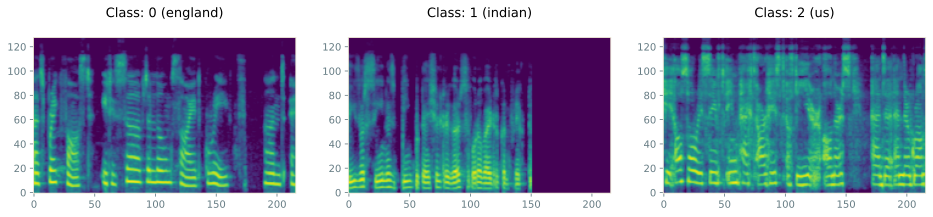

In [49]:
plt.figure(figsize=(16, 4))

for i in range(len(accents_dict)):
    label = list(accents_dict)[i]
    pos = np.where(y_train == label)[0][0]
    img = X_train_ram[pos]
    
    plt.subplot(1, len(accents_dict), i + 1)
    plt.grid()
    plt.imshow(img, origin='lower')
    plt.title(f'Class: {label} ({accents_dict[label]})\n', fontsize=13)

### Helpers

In [50]:
def scheduler(epoch, lr, start=10):
    '''Defines scheduler for LearningRateScheduler'''
    if epoch < start:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def recreate_callbacks(es_patience=10, use_scheduler=True, scheduler_start=10, 
                       checkpoint_name='best_model.h5', best_only=True):
    '''Makes a list with new instances of each tensorflow callback'''
    checkpoint_path = WORK_DIR + checkpoint_name
    callbacks_list = [ModelCheckpoint(checkpoint_path, 
                                      monitor='val_accuracy', 
                                      mode='max', 
                                      save_best_only=best_only, 
                                      verbose=0), 
                      EarlyStopping(monitor='val_accuracy', 
                                    patience=es_patience, 
                                    restore_best_weights=True)]
    if use_scheduler:
        callbacks_list.append(
            LearningRateScheduler(lambda ep, lr: 
                                  scheduler(ep, lr, scheduler_start), 
                                  verbose=1)
        )
    return callbacks_list

In [51]:
def plot_history(history):
    '''Plots history of a trained model'''
    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy', color='firebrick')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc train', 'acc validation'], loc='upper left')
    plt.show()
    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss', color='firebrick')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss train', 'loss validation'], loc='upper left')
    plt.show()

In [52]:
def make_prediction(model, X_test, batch_size):
    '''Makes probabilistic prediction and convert it to class labels'''
    predict = model.predict(X_test, batch_size)
    return np.argmax(predict, axis=-1)

In [53]:
# Helper functions to ease the process of model evaluation

def predict_report(model, X_eval, y_eval, batch_size=None, 
                   accents_dict=accents_dict, set_title=None):
    if set_title: print(f' {set_title} '.center(52, '_'))
    y_pred = make_prediction(model, X_eval, batch_size)
    print(classification_report(y_eval, y_pred, 
                                target_names=accents_dict.values(), 
                                zero_division=0))

def val_test_report(model, X_val, y_val, X_test, y_test, batch_size=None, 
                    accents_dict=accents_dict):
    print(f' Model "{model.name}" evaluation report '.center(52))
    predict_report(model, X_val, y_val, batch_size, 
                   accents_dict=accents_dict, set_title='VALIDATION SET')
    predict_report(model, X_test, y_test, batch_size, 
                   accents_dict=accents_dict, set_title='TEST SET')

In [54]:
# Define Info class for containing some additional info
class Info(L.Layer):
    '''Keras layer as container for additional model info'''
    def __init__(self, accents_dict):
        self.accents_dict = accents_dict
        super().__init__()
    def get_config(self):
        return {'accents_dict': self.accents_dict}

In [55]:
# Helper for making train-val-test sets
make_sets = lambda thresh: {'x': X_train_ram[:thresh], 'y': y_train_ram[:thresh], 
                            'validation_data': (X_val_ram[:thresh], y_val_ram[:thresh])}

## Models

In [56]:
BATCH_SIZE = 64
LR         = 0.001
NUM_EPOCHS = 100

### Baseline Model [Simple Perceptron]

In [70]:
model_sp = Sequential([
    Input(shape=INPUT_SHAPE), 
    
    L.Dense(512, activation='relu'), 
    L.Flatten(), 
    L.Dense(NUM_CLASSES, activation='softmax'), 
    
    Info(accents_dict)
], name='SimplePerceptron')


model_sp.compile(optimizer=optimizers.Adam(0.0001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

model_sp.summary()

Model: "SimplePerceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 512)          111104    
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 196611    
_________________________________________________________________
info (Info)                  (None, 3)                 0         
Total params: 307,715
Trainable params: 307,715
Non-trainable params: 0
_________________________________________________________________


In [71]:
%%time

# data_filepath = DATA_PATH + MELSPECS_FILENAME
# train_gen, val_gen = recreate_generators(data_filepath, 
#                                          X_train, y_train, X_val, y_val)


history_model_sp = model_sp.fit(**make_sets(thresh=None), 
                                class_weight=get_class_weights(y_train), 
                                batch_size=BATCH_SIZE, 
                                epochs=60,
                                callbacks=recreate_callbacks(
                                    15, use_scheduler=True), 
                                verbose=2)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
359/359 - 3s - loss: 10.8534 - accuracy: 0.3729 - val_loss: 4.9674 - val_accuracy: 0.4067
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
359/359 - 2s - loss: 4.6938 - accuracy: 0.4127 - val_loss: 5.6008 - val_accuracy: 0.3605
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
359/359 - 2s - loss: 3.3366 - accuracy: 0.4468 - val_loss: 2.7970 - val_accuracy: 0.4385
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
359/359 - 2s - loss: 2.5292 - accuracy: 0.4664 - val_loss: 2.6650 - val_accuracy: 0.4057
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
359/359 - 2s - loss: 2.0201 - accuracy: 0.4936 - val_loss: 2.3682 - val_accuracy: 0.4148
Epoch 6/60

Epoch 00006: LearningRateScheduler reducing learning rate to 9

In [61]:
val_test_report(model_sp, X_val_ram, y_val, X_test_ram, y_test)

     Model "SimplePerceptron" evaluation report     
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     african       0.05      0.01      0.01       118
   australia       0.09      0.01      0.02       781
     england       0.23      0.94      0.37      1414
      indian       0.34      0.02      0.03      1266
     ireland       0.07      0.01      0.01       524
    scotland       0.06      0.01      0.01       611
          us       0.19      0.01      0.02      1332

    accuracy                           0.23      6046
   macro avg       0.15      0.14      0.07      6046
weighted avg       0.19      0.23      0.10      6046

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     african       0.00      0.00      0.00        81
   australia       0.12      0.01      0.02       594
     england       0.22      0.95      0.36       986
      indian       0.26    

In [77]:
val_test_report(model_sp, X_val_ram, y_val, X_test_ram, y_test)

     Model "SimplePerceptron" evaluation report     
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.47      0.47      0.47      1371
      indian       0.51      0.58      0.54      1354
          us       0.42      0.35      0.38      1325

    accuracy                           0.47      4050
   macro avg       0.46      0.47      0.46      4050
weighted avg       0.46      0.47      0.46      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.43      0.43      0.43      1017
      indian       0.50      0.57      0.53       988
          us       0.38      0.33      0.35       995

    accuracy                           0.44      3000
   macro avg       0.44      0.44      0.44      3000
weighted avg       0.44      0.44      0.44      3000



In [80]:
predict_report(model_sp, X_adb_ram, y_adb, set_title='AccentDB')               

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.44      0.41      0.42      2000
      indian       0.48      0.38      0.42      2000
          us       0.35      0.45      0.39      2000

    accuracy                           0.41      6000
   macro avg       0.42      0.41      0.41      6000
weighted avg       0.42      0.41      0.41      6000



In [79]:
predict_report(model_sp, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.40      0.30      0.34      2000
      indian       0.42      0.58      0.49      2000
          us       0.36      0.31      0.34      2000

    accuracy                           0.40      6000
   macro avg       0.39      0.40      0.39      6000
weighted avg       0.39      0.40      0.39      6000



In [73]:
predict_examples(model_sp, X_ex_ram, y_ex)

Accuracy: 0.3


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,indian
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
England 1,Upper-class Accent Examples,england,england
England 2,Upper-class Accent Examples,england,england
England 3,Upper-class Accent Examples,england,indian
Indian 1,Can you understand Indian English Accent?,indian,england
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,england
Indian 3,A Sampling of Indian English Accents,indian,indian


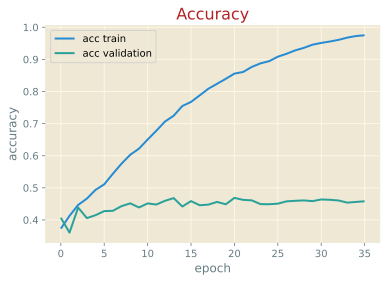

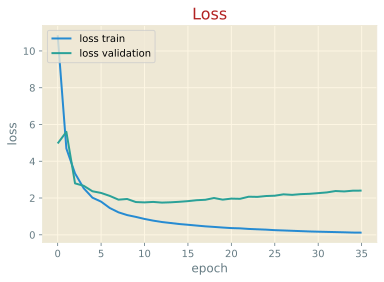

In [75]:
plot_history(history_model_sp)

### CNN 1D

In [82]:
NUM_FILTERS   = 64
FILTER_SIZE_1 = 10
FILTER_SIZE_2 = 7
FILTER_SIZE_3 = 5

BATCH_SIZE = 64
LR         = 0.001
NUM_EPOCHS = 100

In [83]:
# CNN: Convolution1D
model_cnn1d = Sequential([
    Input(shape=INPUT_SHAPE), 
    
    # Layer 1
    # Add a Convolution1D which will learn NUM_FILTERS mfcc groups:
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_1, 
             padding='valid', activation='relu'), 
    L.BatchNormalization(),  # batch-norm to keep weights in [0, 1] range
    L.MaxPooling1D(pool_size=2),  # standard maxpooling to halve the output of previous layer
    
    # Layer 2
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_2, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
    L.MaxPooling1D(pool_size=2), 
        
    # Layer 3
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_3, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
   
    # Flatten the output of the convolutional layers
    L.Flatten(), 
    
    # Dropout reduces overfitting
    L.Dropout(0.5), 
    
    # Project onto a single unit output layer with a softmax activation
    L.Dense(NUM_CLASSES, activation='softmax')
], name='CNN_1D')

    
# Compile the model
model_cnn1d.compile(optimizer=optimizers.Adam(LR, amsgrad=True), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])


model_cnn1d.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 119, 64)           138304    
_________________________________________________________________
batch_normalization (BatchNo (None, 119, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 59, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 64)            28736     
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 29, 64)            20544

In [84]:
%%time

# Fit model
history_cnn1d = model_cnn1d.fit(**make_sets(thresh=None), 
                                class_weight=get_class_weights(y_train), 
                                batch_size=BATCH_SIZE, 
                                epochs=60, 
                                callbacks=recreate_callbacks(15, use_scheduler=True), 
                                verbose=2
                               )

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 8s - loss: 1.3472 - accuracy: 0.3876 - val_loss: 1.1119 - val_accuracy: 0.4077
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 3s - loss: 1.1139 - accuracy: 0.4304 - val_loss: 1.0623 - val_accuracy: 0.4407
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 3s - loss: 1.0640 - accuracy: 0.4535 - val_loss: 1.0636 - val_accuracy: 0.4506
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 3s - loss: 1.0444 - accuracy: 0.4660 - val_loss: 1.1016 - val_accuracy: 0.4227
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 3s - loss: 1.0110 - accuracy: 0.4918 - val_loss: 1.0578 - val_accuracy: 0.4338
Epoch 6/60

Epoch 00006: LearningRateScheduler reducing learning rate to 0.

In [85]:
val_test_report(model_cnn1d, X_val_ram, y_val, X_test_ram, y_test)

          Model "CNN_1D" evaluation report          
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.50      0.61      0.55      1371
      indian       0.60      0.68      0.64      1354
          us       0.50      0.32      0.39      1325

    accuracy                           0.54      4050
   macro avg       0.54      0.54      0.53      4050
weighted avg       0.54      0.54      0.53      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.51      0.62      0.56      1017
      indian       0.59      0.66      0.62       988
          us       0.51      0.34      0.41       995

    accuracy                           0.54      3000
   macro avg       0.54      0.54      0.53      3000
weighted avg       0.54      0.54      0.53      3000



In [87]:
predict_report(model_cnn1d, X_adb_ram, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.41      0.20      0.26      2000
      indian       0.43      0.20      0.27      2000
          us       0.35      0.72      0.47      2000

    accuracy                           0.37      6000
   macro avg       0.40      0.37      0.33      6000
weighted avg       0.40      0.37      0.33      6000



In [88]:
predict_report(model_cnn1d, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.45      0.51      0.48      2000
      indian       0.44      0.56      0.49      2000
          us       0.33      0.20      0.25      2000

    accuracy                           0.42      6000
   macro avg       0.41      0.42      0.41      6000
weighted avg       0.41      0.42      0.41      6000



In [89]:
predict_examples(model_cnn1d, X_ex_ram, y_ex)

Accuracy: 0.6


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,england
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
England 1,Upper-class Accent Examples,england,england
England 2,Upper-class Accent Examples,england,england
England 3,Upper-class Accent Examples,england,england
Indian 1,Can you understand Indian English Accent?,indian,england
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,england
Indian 3,A Sampling of Indian English Accents,indian,indian


#### Plot History

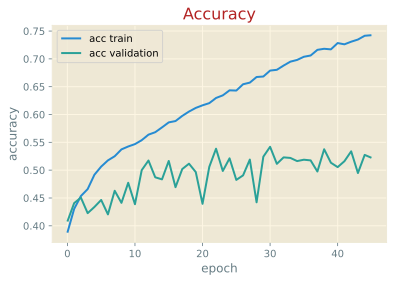

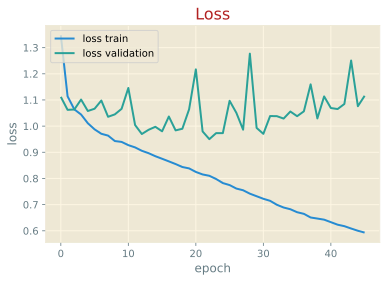

In [90]:
plot_history(history_cnn1d)

### CNN 1D [x]

In [92]:
model_cnn1d_xxx = Sequential([
    Input(shape=INPUT_SHAPE), 
    
    L.Conv1D(32, (3), padding='valid', activation='relu'), 
    L.BatchNormalization(), 
    L.MaxPooling1D(pool_size=2), 
    
    L.Conv1D(32, (3), padding='valid', activation='relu'), 
    L.BatchNormalization(), 
    L.MaxPooling1D(pool_size=2), 
    
    L.Conv1D(64, (3), padding='valid', activation='relu'), 
    L.BatchNormalization(), 

    # Flatten the output of the convolutional layers
    L.Flatten(), 
    L.Dense(128, activation='relu'), 
    L.Dropout(0.5), 
    L.Dense(32, activation='relu'), 
    L.Dropout(0.25), 
    
    # Project onto a single unit output layer with a softmax activation
    L.Dense(NUM_CLASSES, activation='softmax', 
#             kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.0001)
            )
], name='CNN_1D_x')


# Compile the model
optimizer = optimizers.Adam(LR, amsgrad=True)

model_cnn1d_x.compile(optimizer=optimizer, 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])


model_cnn1d_x.summary()

Model: "CNN_1D_xxx"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 126, 32)           20768     
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 63, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 32)            3104      
_________________________________________________________________
batch_normalization_4 (Batch (None, 61, 32)            128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 30, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 28, 64)            6

In [93]:
%%time

history_cnn1d_x = model_cnn1d_x.fit(**make_sets(thresh=None), 
                                    class_weight=get_class_weights(y_train), 
                                    batch_size=BATCH_SIZE, 
                                    epochs=80, 
                                    callbacks=recreate_callbacks(15, use_scheduler=True), 
                                    verbose=2)

Epoch 1/80

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 7s - loss: 1.1373 - accuracy: 0.3771 - val_loss: 1.0913 - val_accuracy: 0.3704
Epoch 2/80

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 4s - loss: 1.0768 - accuracy: 0.4117 - val_loss: 1.0633 - val_accuracy: 0.4291
Epoch 3/80

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 4s - loss: 1.0548 - accuracy: 0.4343 - val_loss: 1.0581 - val_accuracy: 0.4249
Epoch 4/80

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 4s - loss: 1.0342 - accuracy: 0.4556 - val_loss: 1.0353 - val_accuracy: 0.4600
Epoch 5/80

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 4s - loss: 1.0099 - accuracy: 0.4749 - val_loss: 1.0134 - val_accuracy: 0.4820
Epoch 6/80

Epoch 00006: LearningRateScheduler reducing learning rate to 0.

In [94]:
val_test_report(model_cnn1d_x, X_val_ram, y_val, X_test_ram, y_test)

        Model "CNN_1D_xxx" evaluation report        
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.62      0.59      0.61      1371
      indian       0.68      0.67      0.68      1354
          us       0.52      0.55      0.53      1325

    accuracy                           0.61      4050
   macro avg       0.61      0.60      0.61      4050
weighted avg       0.61      0.61      0.61      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.63      0.61      0.62      1017
      indian       0.68      0.68      0.68       988
          us       0.53      0.54      0.53       995

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



In [95]:
predict_report(model_cnn1d_x, X_adb_ram, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.34      0.23      0.27      2000
      indian       0.37      0.25      0.30      2000
          us       0.24      0.41      0.31      2000

    accuracy                           0.29      6000
   macro avg       0.32      0.29      0.29      6000
weighted avg       0.32      0.29      0.29      6000



In [96]:
predict_report(model_cnn1d_x, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.47      0.31      0.37      2000
      indian       0.46      0.64      0.53      2000
          us       0.35      0.33      0.34      2000

    accuracy                           0.43      6000
   macro avg       0.42      0.43      0.41      6000
weighted avg       0.42      0.43      0.41      6000



In [97]:
predict_examples(model_cnn1d_x, X_ex_ram, y_ex)

Accuracy: 0.4


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,us
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
England 1,Upper-class Accent Examples,england,us
England 2,Upper-class Accent Examples,england,england
England 3,Upper-class Accent Examples,england,us
Indian 1,Can you understand Indian English Accent?,indian,england
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,england
Indian 3,A Sampling of Indian English Accents,indian,indian


#### Plot History

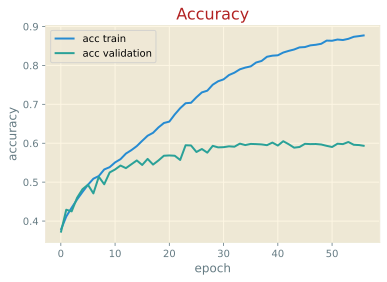

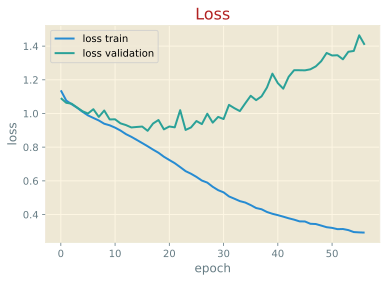

In [99]:
plot_history(history_cnn1d_x)

### CNN1D [Reshma]

In [100]:
model_cnn1d_reshma = Sequential([
    Input(shape=INPUT_SHAPE), 
    
    L.Conv1D(32, 3, 
           padding='same', activation='linear'), 
    L.LeakyReLU(alpha=0.1), 
    L.MaxPooling1D((2), padding='same'), 

    L.Conv1D(128, 3, 
           padding='same', activation='linear'), 
    L.LeakyReLU(alpha=0.1), 
    L.MaxPooling1D((2), padding='same'), 

    L.Conv1D(128, 3, 
           padding='same', activation='linear'), 
    L.LeakyReLU(alpha=0.1), 
    L.MaxPooling1D((2), padding='same'), 

    L.Flatten(), 

    L.Dense(128, activation='linear'), 
    L.LeakyReLU(alpha=0.1), 
    L.Dense(NUM_CLASSES, activation='softmax')
], name='Conv1D_Reshma')
    
    
# Compile the model
optimizer = optimizers.Adam(LR, amsgrad=True)

model_cnn1d_reshma.compile(optimizer=optimizer, 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

model_cnn1d_reshma.summary()

Model: "Conv1D_Reshma"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 128, 32)           20768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 32)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 64, 128)           12416     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 128)         

In [101]:
%%time

# Fit model
history_cnn1d_reshma = model_cnn1d_reshma.fit(**make_sets(thresh=None), 
                                              class_weight=get_class_weights(y_train), 
                                              batch_size=BATCH_SIZE, 
                                              epochs=60, 
                                              callbacks=recreate_callbacks(15, use_scheduler=True), 
                                              verbose=1)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 [==============================] - 5s 13ms/step - loss: 6.7279 - accuracy: 0.3493 - val_loss: 1.0811 - val_accuracy: 0.3938
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 [==============================] - 4s 12ms/step - loss: 1.0831 - accuracy: 0.3973 - val_loss: 1.0795 - val_accuracy: 0.3933
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 [==============================] - 4s 11ms/step - loss: 1.0639 - accuracy: 0.4271 - val_loss: 1.0678 - val_accuracy: 0.4195
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 [==============================] - 4s 11ms/step - loss: 1.0461 - accuracy: 0.4470 - val_loss: 1.0583 - val_accuracy: 0.4193
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474

In [80]:
val_test_report(model_cnn1d_reshma, X_val_ram, y_val, X_test_ram, y_test)

      Model "Conv1D_Reshma" evaluation report       
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

   australia       0.86      0.86      0.86      1327
      canada       0.86      0.86      0.86      1334
      indian       0.85      0.86      0.85      1340
     ireland       0.88      0.92      0.90       509
    scotland       0.96      0.92      0.94       910

    accuracy                           0.88      5420
   macro avg       0.88      0.88      0.88      5420
weighted avg       0.88      0.88      0.88      5420

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

   australia       0.86      0.86      0.86      1011
      canada       0.85      0.86      0.85      1054
      indian       0.83      0.84      0.83       967
     ireland       0.90      0.89      0.90       378
    scotland       0.95      0.94      0.94       605

    accuracy              

In [102]:
val_test_report(model_cnn1d_reshma, X_val_ram, y_val, X_test_ram, y_test)

      Model "Conv1D_Reshma" evaluation report       
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.53      0.52      0.53      1371
      indian       0.58      0.64      0.61      1354
          us       0.48      0.44      0.46      1325

    accuracy                           0.53      4050
   macro avg       0.53      0.53      0.53      4050
weighted avg       0.53      0.53      0.53      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.52      0.52      0.52      1017
      indian       0.60      0.66      0.63       988
          us       0.48      0.44      0.46       995

    accuracy                           0.54      3000
   macro avg       0.54      0.54      0.54      3000
weighted avg       0.53      0.54      0.54      3000



In [104]:
predict_report(model_cnn1d_reshma, X_adb_ram, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.40      0.12      0.18      2000
      indian       0.37      0.37      0.37      2000
          us       0.30      0.51      0.38      2000

    accuracy                           0.33      6000
   macro avg       0.36      0.33      0.31      6000
weighted avg       0.36      0.33      0.31      6000



In [105]:
predict_report(model_cnn1d_reshma, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.40      0.24      0.30      2000
      indian       0.42      0.68      0.52      2000
          us       0.36      0.29      0.32      2000

    accuracy                           0.40      6000
   macro avg       0.40      0.40      0.38      6000
weighted avg       0.40      0.40      0.38      6000



In [106]:
predict_examples(model_cnn1d_reshma, X_ex_ram, y_ex)

Accuracy: 0.7


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,england
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,england
England 1,Upper-class Accent Examples,england,england
England 2,Upper-class Accent Examples,england,england
England 3,Upper-class Accent Examples,england,england
Indian 1,Can you understand Indian English Accent?,indian,us
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,indian
Indian 3,A Sampling of Indian English Accents,indian,indian


### CNN: VFNet

In [109]:
BATCH_SIZE = 64
LR = 0.001
NUM_EPOCHS = 100

In [115]:
inputs = Input(shape=INPUT_SHAPE)

kernels = [27, 21, 17, 13, 9, 7, 5]

parallel_layers = []
for k in kernels:
    x = L.Conv1D(64, kernel_size=k, padding='valid', activation='relu')(inputs)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling1D(pool_size=2)(x)
    x = L.Dropout(0.25)(x)
    parallel_layers.append(x)

x = L.Concatenate(axis=1)(parallel_layers)
x = L.Dropout(0.25)(x)

x = L.Conv1D(64 * len(kernels), kernel_size=3, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)

x = L.Dense(256)(x)

x = L.Flatten()(x)
outputs = L.Dense(NUM_CLASSES, activation='softmax')(x)


model_cnn_vfnet = Model(
    inputs=inputs, 
    outputs=outputs, 
    name='VFNet'
)


# Compile the model
optimizer = optimizers.Adam(LR, amsgrad=True)

model_cnn_vfnet.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=["accuracy"])

model_cnn_vfnet.summary()

Model: "VFNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 216)]   0                                            
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 102, 64)      373312      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 108, 64)      290368      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 112, 64)      235072      input_7[0][0]                    
______________________________________________________________________________________________

In [117]:
%%time

# Fit model
history_cnn_vfnet = model_cnn_vfnet.fit(**make_sets(thresh=None), 
                                        class_weight=get_class_weights(y_train), 
                                        batch_size=BATCH_SIZE, 
                                        epochs=60, 
                                        callbacks=recreate_callbacks(15, use_scheduler=True), 
                                        verbose=2
                                       )

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 17s - loss: 2.9207 - accuracy: 0.3813 - val_loss: 1.4121 - val_accuracy: 0.4101
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 13s - loss: 1.5203 - accuracy: 0.4079 - val_loss: 1.2051 - val_accuracy: 0.4304
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 13s - loss: 1.3021 - accuracy: 0.4261 - val_loss: 1.1599 - val_accuracy: 0.4321
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 13s - loss: 1.2485 - accuracy: 0.4372 - val_loss: 1.4156 - val_accuracy: 0.3874
Epoch 5/60

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
359/359 - 13s - loss: 1.2204 - accuracy: 0.4425 - val_loss: 1.2700 - val_accuracy: 0.4042
Epoch 6/60

Epoch 00006: LearningRateScheduler reducing learning rate 

In [112]:
val_test_report(model_cnn_vfnet, X_val_ram, y_val, X_test_ram, y_test)

      Model "Conv1D_Reshma" evaluation report       
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

   australia       0.86      0.86      0.86      1327
      canada       0.86      0.86      0.86      1334
      indian       0.85      0.86      0.85      1340
     ireland       0.88      0.92      0.90       509
    scotland       0.96      0.92      0.94       910

    accuracy                           0.88      5420
   macro avg       0.88      0.88      0.88      5420
weighted avg       0.88      0.88      0.88      5420

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

   australia       0.86      0.86      0.86      1011
      canada       0.85      0.86      0.85      1054
      indian       0.83      0.84      0.83       967
     ireland       0.90      0.89      0.90       378
    scotland       0.95      0.94      0.94       605

    accuracy              

In [121]:
val_test_report(model_cnn_vfnet, X_val_ram, y_val, X_test_ram, y_test)

          Model "VFNet" evaluation report           
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.45      0.63      0.53      1371
      indian       0.61      0.51      0.56      1354
          us       0.45      0.34      0.39      1325

    accuracy                           0.50      4050
   macro avg       0.50      0.49      0.49      4050
weighted avg       0.50      0.50      0.49      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.45      0.61      0.52      1017
      indian       0.64      0.55      0.60       988
          us       0.45      0.34      0.39       995

    accuracy                           0.51      3000
   macro avg       0.51      0.50      0.50      3000
weighted avg       0.51      0.51      0.50      3000



In [122]:
predict_report(model_cnn_vfnet, X_adb_ram, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.41      0.55      0.47      2000
      indian       0.47      0.07      0.13      2000
          us       0.35      0.52      0.42      2000

    accuracy                           0.38      6000
   macro avg       0.41      0.38      0.34      6000
weighted avg       0.41      0.38      0.34      6000



In [123]:
predict_report(model_cnn_vfnet, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.38      0.29      0.33      2000
      indian       0.42      0.66      0.51      2000
          us       0.35      0.24      0.28      2000

    accuracy                           0.39      6000
   macro avg       0.38      0.39      0.37      6000
weighted avg       0.38      0.39      0.37      6000



In [124]:
predict_examples(model_cnn_vfnet, X_ex_ram, y_ex)

Accuracy: 0.2


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,england
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,england
England 1,Upper-class Accent Examples,england,us
England 2,Upper-class Accent Examples,england,indian
England 3,Upper-class Accent Examples,england,england
Indian 1,Can you understand Indian English Accent?,indian,us
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,england
Indian 3,A Sampling of Indian English Accents,indian,england


### CNN 2D

In [125]:
model_cnn2d = Sequential([
    L.Reshape((*INPUT_SHAPE, 1), input_shape=INPUT_SHAPE), 
    
    # Level 1
    L.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.Dropout(0.1), 
    L.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.MaxPooling2D(2), 
    
    # Level 2
    L.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.Dropout(0.1), 
    L.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.MaxPooling2D(2), 
        
    # Level 3
    L.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.Dropout(0.1), 
    L.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.MaxPooling2D(2), 

    L.Dropout(0.3), # 0.1
    L.Flatten(), 
    
    L.Dense(256, use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.Dropout(0.2), 

    L.Dense(256, use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('relu'), 
    L.Dropout(0.2), 
    
    # Project onto a single unit output layer with a softmax activation
    L.Dense(NUM_CLASSES, activation='softmax', use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('softmax')
], name='CNN_2D')


# Compile the model
optimizer = optimizers.Adam(LR, amsgrad=True)

model_cnn2d.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

model_cnn2d.summary()

Model: "CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 128, 216, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 214, 16)      144       
_________________________________________________________________
batch_normalization_34 (Batc (None, 126, 214, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 126, 214, 16)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 126, 214, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 212, 16)      2304      
_________________________________________________________________
batch_normalization_35 (Batc (None, 124, 212, 16)      64   

In [ ]:
%%time

# Fit model
model_cnn2d_history = model_cnn2d.fit(**make_sets(thresh=None), 
                                      class_weight=get_class_weights(y_train), 
                                      batch_size=BATCH_SIZE // 16, 
                                      epochs=100, 
                                      callbacks=recreate_callbacks(15, use_scheduler=True), 
                                      verbose=1
                                     )

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
5738/5738 [==============================] - 76s 13ms/step - loss: 1.0964 - accuracy: 0.3665 - val_loss: 1.0975 - val_accuracy: 0.3617
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
5738/5738 [==============================] - 74s 13ms/step - loss: 1.0949 - accuracy: 0.3539 - val_loss: 1.1126 - val_accuracy: 0.3642
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
5738/5738 [==============================] - 74s 13ms/step - loss: 1.0796 - accuracy: 0.3986 - val_loss: 1.0614 - val_accuracy: 0.4356
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
5738/5738 [==============================] - 74s 13ms/step - loss: 1.0654 - accuracy: 0.4275 - val_loss: 1.0881 - val_accuracy: 0.4054
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate t

In [68]:
val_test_report(model_cnn2d, X_val_ram, y_val, X_test_ram, y_test)

          Model "CNN_2D" evaluation report          
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     african       0.73      0.43      0.54       118
   australia       0.79      0.58      0.66       781
     england       0.69      0.73      0.71      1414
      indian       0.76      0.86      0.81      1266
     ireland       0.95      0.80      0.87       524
    scotland       0.93      0.88      0.90       611
          us       0.58      0.64      0.61      1332

    accuracy                           0.73      6046
   macro avg       0.78      0.70      0.73      6046
weighted avg       0.74      0.73      0.73      6046

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     african       0.75      0.41      0.53        81
   australia       0.80      0.58      0.67       594
     england       0.67      0.75      0.70       986
      indian       0.76    

In [143]:
predict_report(model_cnn2d, X_adb_ram, y_adb)

NameError: name 'model_cnn2d' is not defined

In [74]:
predict_report(model_cnn2d, X_vc_ram, y_vc)

              precision    recall  f1-score   support

     african       0.03      0.00      0.01       261
   australia       0.22      0.08      0.12      2000
     england       0.27      0.32      0.30      2000
      indian       0.35      0.60      0.44      2000
     ireland       0.19      0.01      0.01      2000
    scotland       0.00      0.00      0.00         0
          us       0.27      0.48      0.35      2000

    accuracy                           0.29     10261
   macro avg       0.19      0.21      0.17     10261
weighted avg       0.26      0.29      0.24     10261



In [73]:
predict_examples(model_cnn2d, X_ex_ram, y_ex)

Accuracy: 0.5


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,canada
English 1,Upper-class Accent Examples,england,england
English 2,Natalie Hockham: Machine learning with imbalan...,england,indian
Indian 1,Can you understand Indian English Accent?,indian,us
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,indian
Indian 3,A Sampling of Indian English Accents,indian,indian


### CNN: takikhasan/English-Accent-Detection

In [108]:
model_cnn2d_takikhasan = Sequential([
    L.Reshape((*INPUT_SHAPE, 1), input_shape=INPUT_SHAPE), 
    
    # 1st conv layer
    L.Conv2D(32, kernel_size=3, activation='relu'), 
    L.BatchNormalization(), 
    L.Conv2D(32, kernel_size=3, activation='relu'), 
    L.BatchNormalization(), 
    L.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'), 
    L.BatchNormalization(), 
    L.Dropout(0.5), 

    # 2nd conv layer
    L.Conv2D(64, kernel_size=3, activation='relu'), 
    L.BatchNormalization(), 
    L.Conv2D(64, kernel_size=3, activation='relu'), 
    L.BatchNormalization(), 
    L.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'), 
    L.BatchNormalization(), 
    L.Dropout(0.5), 

    # flatten output and feed it into dense layer
    L.Flatten(), 
    L.Dense(128, activation='relu'), 
    L.BatchNormalization(), 
    L.Dropout(0.5), 

    # output layer
    L.Dense(NUM_CLASSES, activation='softmax')
])


# compile model
model_cnn2d_takikhasan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
#                                loss='sparse_categorical_crossentropy',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

model_cnn2d_takikhasan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 216, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 214, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 126, 214, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 212, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 124, 212, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 106, 32)       25632     
_________________________________________________________________
batch_normalization_16 (Batc (None, 62, 106, 32)       1

In [71]:
%%time

checkpoint_name = 'cnn2d_takikhasan_3x10000_ep{epoch:02d}-acc{val_accuracy:.2f}.h5'
history_cnn2d_takikhasan = model_cnn2d_takikhasan.fit(**make_sets(thresh=None), 
                                                      class_weight=get_class_weights(y_train), 
                                                      batch_size=BATCH_SIZE, 
                                                      epochs=50, 
                                                      callbacks=recreate_callbacks(
                                                          15, use_scheduler=True, 
                                                          checkpoint_name=checkpoint_name
                                                      ), 
                                                      verbose=1)

Epoch 1/50
351/351 [==============================] - 69s 188ms/step - loss: 1.4258 - accuracy: 0.4224 - val_loss: 1.0278 - val_accuracy: 0.4970
Epoch 2/50
351/351 [==============================] - 64s 181ms/step - loss: 0.9955 - accuracy: 0.5142 - val_loss: 1.3147 - val_accuracy: 0.4780
Epoch 3/50
351/351 [==============================] - 63s 181ms/step - loss: 0.8717 - accuracy: 0.5799 - val_loss: 1.0156 - val_accuracy: 0.5265
Epoch 4/50
351/351 [==============================] - 64s 181ms/step - loss: 0.8060 - accuracy: 0.6199 - val_loss: 0.8969 - val_accuracy: 0.5801
Epoch 5/50
351/351 [==============================] - 64s 181ms/step - loss: 0.7342 - accuracy: 0.6641 - val_loss: 1.5471 - val_accuracy: 0.4354
Epoch 6/50
351/351 [==============================] - 63s 181ms/step - loss: 0.6650 - accuracy: 0.7020 - val_loss: 1.0094 - val_accuracy: 0.5604
Epoch 7/50
351/351 [==============================] - 63s 181ms/step - loss: 0.6170 - accuracy: 0.7235 - val_loss: 0.8620 - val_ac

### CNN: EfficientNet [Transfer Learning]

In [102]:
from tensorflow.keras.applications import efficientnet as efn

efnet = efn.EfficientNetB6(include_top=False, 
                           weights='imagenet', 
                           input_tensor=None, 
                           input_shape=(*INPUT_SHAPE, 3))


model_efnet = Sequential([
    L.Reshape((*INPUT_SHAPE, 1), input_shape=INPUT_SHAPE), 
    L.Conv2D(3, (3, 3), padding='same'),  # adapt for efnet's 3 channels

    efnet, 

    L.Flatten(), 
    L.Dropout(0.5), 
    
    L.Dense(NUM_CLASSES, use_bias=False), 
    L.BatchNormalization(), 
    L.Activation('softmax'),

    Info(accents_dict)
], name=efnet.name)
    

# Compile the model
model_efnet.compile(optimizer=optimizers.Adam(LR, amsgrad=True), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

model_efnet.summary()

Model: "efficientnetb6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 216, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 216, 3)       30        
_________________________________________________________________
efficientnetb6 (Functional)  (None, 4, 7, 2304)        40960143  
_________________________________________________________________
flatten (Flatten)            (None, 64512)             0         
_________________________________________________________________
dropout (Dropout)            (None, 64512)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 193536    
_________________________________________________________________
batch_normalization (BatchNo (None, 3)              

In [103]:
%%time

checkpoint_name = 'EfficientNet/' + model_efnet.name + '_B6_3x10000_{epoch:02d}-acc{val_accuracy:.2f}.h5'

history_model_efnet = model_efnet.fit(**make_sets(thresh=None), 
                                      class_weight=get_class_weights(y_train), 
                                      batch_size=BATCH_SIZE // 2, 
                                      epochs=100, 
                                      callbacks=recreate_callbacks(
                                          20, use_scheduler=True, scheduler_start=0, 
                                          checkpoint_name=checkpoint_name, 
                                          best_only=False
                                      ), 
                                      verbose=1)

Epoch 1/11

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
718/718 [==============================] - 546s 722ms/step - loss: 0.9558 - accuracy: 0.5419 - val_loss: 0.7670 - val_accuracy: 0.6773
Epoch 2/11

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009512295, shape=(), dtype=float32).
718/718 [==============================] - 513s 715ms/step - loss: 0.6697 - accuracy: 0.7258 - val_loss: 0.7726 - val_accuracy: 0.6602
Epoch 3/11

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009048375, shape=(), dtype=float32).
718/718 [==============================] - 514s 716ms/step - loss: 0.5436 - accuracy: 0.7881 - val_loss: 0.6413 - val_accuracy: 0.7353
Epoch 4/11

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.00086070807, shape=(), dtype=float32).
718/718 [==============================] - 513s 714ms/step - loss: 0.4388 - accuracy: 0.8376 - val_loss: 0.6199 - val_accuracy: 0

In [82]:
val_test_report(model_efnet, X_val_ram, y_val, X_test_ram, y_test, 
                accents_dict=model_efnet.layers[-1].accents_dict)

      Model "efficientnetb6" evaluation report      
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.68      0.94      0.79      1371
      indian       0.89      0.88      0.89      1354
          us       0.90      0.56      0.69      1325

    accuracy                           0.80      4050
   macro avg       0.82      0.79      0.79      4050
weighted avg       0.82      0.80      0.79      4050

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.67      0.93      0.78      1017
      indian       0.87      0.87      0.87       988
          us       0.88      0.53      0.66       995

    accuracy                           0.78      3000
   macro avg       0.81      0.78      0.77      3000
weighted avg       0.81      0.78      0.77      3000



In [84]:
predict_report(model_efnet, X_adb_ram, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.60      0.83      0.70      2000
      indian       0.82      0.73      0.77      2000
          us       0.83      0.60      0.70      2000

    accuracy                           0.72      6000
   macro avg       0.75      0.72      0.72      6000
weighted avg       0.75      0.72      0.72      6000



In [87]:
predict_report(model_efnet, X_vc_ram, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.52      0.75      0.62      2000
      indian       0.79      0.56      0.66      2000
          us       0.66      0.57      0.61      2000

    accuracy                           0.63      6000
   macro avg       0.66      0.63      0.63      6000
weighted avg       0.66      0.63      0.63      6000



In [86]:
predict_examples(model_efnet, X_ex_ram, y_ex)

Accuracy: 0.9


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,england
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
US 2,4 secrets of how to get an American accent in ...,us,us
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,england
England 1,Upper-class Accent Examples,england,england
England 2,Upper-class Accent Examples,england,england
England 3,Upper-class Accent Examples,england,england
Indian 1,Can you understand Indian English Accent?,indian,indian
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,indian
Indian 3,A Sampling of Indian English Accents,indian,indian


In [ ]:
# Fit model (melspecs) [efnB6; 5x10000]
model_efnet._name = 'efnet_B6_5x10000'

history_model_efnet = model_efnet.fit(#train_gen, 
                                      #validation_data=(val_gen), 
                                      X_train_ram, y_train_ram, 
                                      validation_data=(X_val_ram, y_val_ram), 
                                      batch_size=BATCH_SIZE // 2, 
                                      epochs=6,#NUM_EPOCHS, 
                                      callbacks=recreate_callbacks(10, use_scheduler=True), 
                                      verbose=1)

## Deep Learning for MFCCs

### RNN: BLSTM

In [67]:
# Set parameters

NUM_LSTM_UNITS = 64 * 16 # 350

LR = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 80

In [68]:
# Build RNN (Bidirectional LSTM) model

# def train_blstm_model(train_X, Y_train, val_X, Y_val, input_shape):
#     '''
#     :param train_X     : Predictor array for train data (mfccs, filterbanks, delta_1, delta_2)
#     '''

input_width = X_feat_train.shape[1]

model_rnn = Sequential([
#     Input((82,)), 
    L.Reshape((input_width, 1), input_shape=(input_width,)),
    
    # note that it is necessary to pass in 3d batch_input_shape if stateful=True
    L.Bidirectional(L.LSTM(NUM_LSTM_UNITS, return_sequences=True, stateful=False)), 
#                            batch_input_shape=(BATCH_SIZE, input_shape))), 
    L.Bidirectional(L.LSTM(NUM_LSTM_UNITS, return_sequences=True, stateful=False)), 
    L.Bidirectional(L.LSTM(NUM_LSTM_UNITS, stateful=False)), 
    
    # add dropout to control for overfitting
    L.Dropout(0.5), 
    
    # output with a softmax activation for multiclass classification
    L.Dense(NUM_CLASSES, 
            activation='softmax', 
            # kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.0001)
            )
], name='BLSTM')


# Compile the model
model_rnn.compile(optimizer=optimizers.Adam(LR, amsgrad=True), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy']) # [convo_f1_score]

model_rnn.summary()

Model: "BLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 26, 1)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 2048)          8404992   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 26, 2048)          25174016  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2048)              25174016  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 58,759,171
Trainable params: 58,759,171
Non-trainable params: 0
_________________________________________________

In [69]:
%%time

checkpoint_name = 'BLSTM/' + model_rnn.name + '_new2_3x10000_ep{epoch:02d}-acc{val_accuracy:.2f}.h5'

history_model_rnn = model_rnn.fit(X_feat_train, y_feat_train, 
                                  validation_data=(X_feat_val, y_feat_val), 
                                  class_weight=get_class_weights(y_feat_train), 
                                  batch_size=64, #BATCH_SIZE, 
                                  epochs=100, 
                                  callbacks=recreate_callbacks(
                                      20, use_scheduler=True, 
                                      checkpoint_name=checkpoint_name, 
                                      best_only=True
                                  ),
                                  verbose=1)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
352/352 [==============================] - 66s 158ms/step - loss: 1.1005 - accuracy: 0.3659 - val_loss: 1.1109 - val_accuracy: 0.3317
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
352/352 [==============================] - 53s 151ms/step - loss: 1.1056 - accuracy: 0.3718 - val_loss: 1.0885 - val_accuracy: 0.3846
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
352/352 [==============================] - 53s 152ms/step - loss: 1.0694 - accuracy: 0.4147 - val_loss: 1.0765 - val_accuracy: 0.4340
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
352/352 [==============================] - 53s 152ms/step - loss: 1.0598 - accuracy: 0.4318 - val_loss: 1.0553 - val_accuracy: 0.4454
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.

In [62]:
model_rnn = load_model('work/BLSTM/BLSTM_new2_3x10000_ep23-acc0.62.h5', 
                       custom_objects={'Info': Info})

In [68]:
val_test_report(model_rnn, X_feat_val, y_feat_val, X_feat_test, y_feat_test)

          Model "BLSTM" evaluation report           
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

     england       0.91      0.91      0.91      1361
      indian       0.91      0.86      0.88      1310
          us       0.86      0.91      0.88      1294

    accuracy                           0.89      3965
   macro avg       0.89      0.89      0.89      3965
weighted avg       0.89      0.89      0.89      3965

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

     england       0.79      0.89      0.84       982
      indian       0.83      0.85      0.84       982
          us       0.81      0.68      0.74       973

    accuracy                           0.81      2937
   macro avg       0.81      0.81      0.81      2937
weighted avg       0.81      0.81      0.81      2937



In [69]:
predict_report(model_rnn, X_feat_adb, y_adb, set_title='AccentDB')

_____________________ AccentDB _____________________
              precision    recall  f1-score   support

     england       0.46      0.36      0.41      2000
      indian       0.33      0.13      0.19      2000
          us       0.39      0.70      0.50      2000

    accuracy                           0.40      6000
   macro avg       0.39      0.40      0.36      6000
weighted avg       0.39      0.40      0.36      6000



In [70]:
predict_report(model_rnn, X_feat_vc, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

     england       0.40      0.29      0.34      2000
      indian       0.47      0.42      0.44      2000
          us       0.34      0.47      0.39      2000

    accuracy                           0.39      6000
   macro avg       0.40      0.39      0.39      6000
weighted avg       0.40      0.39      0.39      6000



In [71]:
predict_examples(model_rnn, X_feat_ex, y_ex)

Accuracy: 0.2


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,indian
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,indian
England 1,Upper-class Accent Examples,england,us
England 2,Upper-class Accent Examples,england,indian
England 3,Upper-class Accent Examples,england,indian
Indian 1,Can you understand Indian English Accent?,indian,indian
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,indian
Indian 3,A Sampling of Indian English Accents,indian,us


### _test_ CNN1d for mfcc

In [164]:
NUM_FILTERS   = 64
FILTER_SIZE_1 = 10
FILTER_SIZE_2 = 7
FILTER_SIZE_3 = 5

BATCH_SIZE = 64
LR         = 0.001
NUM_EPOCHS = 100

In [165]:
input_width = X_feat_train.shape[1]
input_width

26

In [170]:
# CNN: Convolution1D
model_cnn1d_tmp = Sequential([
#     L.Reshape((INPUT_SHAPE[0] * INPUT_SHAPE[1], 1), 
#               input_shape=INPUT_SHAPE), 
    L.Reshape((input_width, 1), input_shape=(input_width,)),
#     Input(shape=INPUT_SHAPE), 
    
    # Layer 1
    # Add a Convolution1D which will learn NUM_FILTERS mfcc groups:
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_1, 
             padding='valid', activation='relu'), 
    L.BatchNormalization(),  # batch-norm to keep weights in [0, 1] range
    L.MaxPooling1D(pool_size=2),  # standard maxpooling to halve the output of previous layer
    
    # Layer 2
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_2, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
    L.MaxPooling1D(pool_size=2), 
        
    # Layer 3
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_3, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
   
    # Flatten the output of the convolutional layers
    L.Flatten(), 
    
    # Dropout reduces overfitting
    L.Dropout(0.5), 
    
    # Project onto a single unit output layer with a softmax activation
    L.Dense(NUM_CLASSES, activation='softmax', 
#             kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.0001)
            )
], name='CNN_1D_tmp')

    
# Compile the model
model_cnn1d_tmp.compile(optimizer=optimizers.Adam(LR, amsgrad=True), # 'rmsprop' # optimizers.Adamax(LR)
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])


model_cnn1d_tmp.summary()

Model: "CNN_1D_tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 26, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 17, 64)            704       
_________________________________________________________________
batch_normalization_10 (Batc (None, 17, 64)            256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8, 64)             28736     
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 64)             256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 64)             0

In [172]:
%%time

checkpoint_name = model_cnn1d_tmp.name + '_mfccs_table_5x10000_ep{epoch:02d}-acc{val_accuracy:.2f}.h5'

history_model_cnn1d_tmp = model_cnn1d_tmp.fit(X_feat_train, y_feat_train, 
                                              validation_data=(X_feat_val, y_feat_val), 
                                              class_weight=get_class_weights(y_feat_train), 
                                              batch_size=64, #5000, #BATCH_SIZE, 
                                              epochs=60, 
                                              callbacks=recreate_callbacks(
                                                  20, use_scheduler=True, 
                                                  checkpoint_name=checkpoint_name, 
                                                  best=True
                                              ),
                                              verbose=1)

Epoch 1/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7986 - accuracy: 0.6723 - val_loss: 1.0951 - val_accuracy: 0.5945
Epoch 2/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7946 - accuracy: 0.6730 - val_loss: 1.0680 - val_accuracy: 0.5891
Epoch 3/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7845 - accuracy: 0.6752 - val_loss: 1.0890 - val_accuracy: 0.5881
Epoch 4/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7785 - accuracy: 0.6814 - val_loss: 1.0298 - val_accuracy: 0.5975
Epoch 5/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7709 - accuracy: 0.6780 - val_loss: 1.1010 - val_accuracy: 0.5945
Epoch 6/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7686 - accuracy: 0.6826 - val_loss: 1.0747 - val_accuracy: 0.6011
Epoch 7/60
538/538 [==============================] - 4s 7ms/step - loss: 0.7591 - accuracy: 0.6867 - val_loss: 1.0793 - val_accuracy: 0.6045
Epoch 

In [173]:
val_test_report(model_cnn1d_tmp, X_feat_val, y_feat_val, X_feat_test, y_feat_test)

        Model "CNN_1D_tmp" evaluation report        
__________________ VALIDATION SET __________________
              precision    recall  f1-score   support

   australia       0.63      0.66      0.65       794
      canada       0.68      0.70      0.69      1223
     england       0.65      0.58      0.61      1382
      indian       0.68      0.72      0.70      1301
          us       0.50      0.49      0.49      1374

    accuracy                           0.63      6074
   macro avg       0.63      0.63      0.63      6074
weighted avg       0.63      0.63      0.63      6074

_____________________ TEST SET _____________________
              precision    recall  f1-score   support

   australia       0.61      0.63      0.62       586
      canada       0.69      0.72      0.70       921
     england       0.61      0.59      0.60      1007
      indian       0.69      0.66      0.68       999
          us       0.46      0.46      0.46       986

    accuracy              

In [174]:
predict_report(model_cnn1d_tmp, X_feat_adb, y_adb, set_title='AccentDB')

____________________ AccentsDB _____________________
              precision    recall  f1-score   support

   australia       0.43      0.10      0.16      1484
      canada       0.00      0.00      0.00         0
     england       0.07      0.07      0.07      1484
      indian       0.11      0.02      0.03      1484
          us       0.16      0.34      0.21      1484

    accuracy                           0.13      5936
   macro avg       0.15      0.10      0.09      5936
weighted avg       0.19      0.13      0.12      5936



In [175]:
predict_report(model_cnn1d_tmp, X_feat_vc, y_vc, set_title='VoxCeleb')

_____________________ VoxCeleb _____________________
              precision    recall  f1-score   support

   australia       0.25      0.16      0.20      2000
      canada       0.24      0.29      0.26      2000
     england       0.27      0.14      0.18      2000
      indian       0.46      0.30      0.37      2000
          us       0.21      0.42      0.28      2000

    accuracy                           0.26     10000
   macro avg       0.29      0.26      0.26     10000
weighted avg       0.29      0.26      0.26     10000



In [176]:
predict_examples(model_cnn1d_tmp, X_feat_ex, y_ex)

Accuracy: 0.3125


,title,accent,predicted
Star Wars,"Star Wars: Obi-Wan Says ""Hello There""",england,england
US 1,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
US 2,4 secrets of how to get an American accent in ...,us,indian
US 3,"ONE language, THREE accents - UK vs. USA vs. A...",us,us
England 1,Upper-class Accent Examples,england,canada
England 2,Upper-class Accent Examples,england,canada
England 3,Upper-class Accent Examples,england,us
Indian 1,Can you understand Indian English Accent?,indian,indian
Indian 2,The Big Bang Theory S06E06 Indian accent,indian,england
Indian 3,A Sampling of Indian English Accents,indian,canada
